# Bigram Name-Like Word Generator

<p align="center"><img src="./bigram.png"></p>

This is a Python script that implements a bigram model to generate new name-like words. It uses a dataset of names to learn the patterns of character pairs in names and then generates new words based on these learned patterns. Below are the key steps and concepts used in this script:

## Table of Contents
- [Data Loading](#data-loading)
- [Character Bigram Count](#character-bigram-count)
- [Visualizing Character Bigram Counts](#visualizing-character-bigram-counts)
- [Character Bigram Probabilities](#character-bigram-probabilities)
- [Visualizing Character Bigram Probabilities](#visualizing-character-bigram-probabilities)
- [Iterative Sampling](#iterative-sampling)
- [Loss Function](#loss-function)

### Data Loading

The script starts by loading a dataset of names from a file named "names.txt". The dataset is split into individual names.

In [ ]:
from pathlib import Path

data_file = Path("data/names.txt")
data = data_file.read_text().split()

### Character Bigram Count

A bigram model is built to count the occurrences of character pairs in the names. Special characters '.' are added to represent the start and end of names. This model calculates the frequency of each character bigram.


In [6]:
count = {}
special_char = "." # this resembles the start and end for the names.
for name in data:
    word = f"{special_char}{name}{special_char}"
    for ch1, ch2 in zip(word, word[1:]):
        bigram = (ch1, ch2)
        count[bigram] = count.get(bigram, 0) + 1

chars = sorted(list(set(".".join(data))))

stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

### Visualizing Character Bigram Counts

The character bigram counts are visualized using a heatmap, providing insights into the frequency of character pairs in the dataset.

In [8]:
import torch

N = torch.zeros((27,27), dtype=torch.int32)
special_char = "." # this resembles the start and end for the names.
for name in data:
    word = f"{special_char}{name}{special_char}"
    for ch1, ch2 in zip(word, word[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1,ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

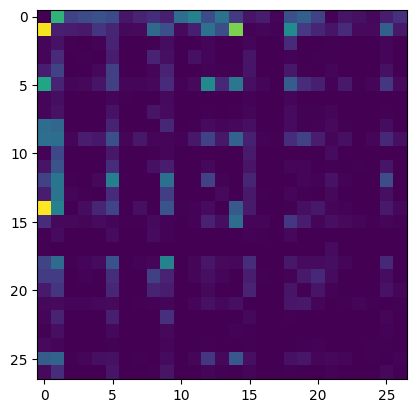

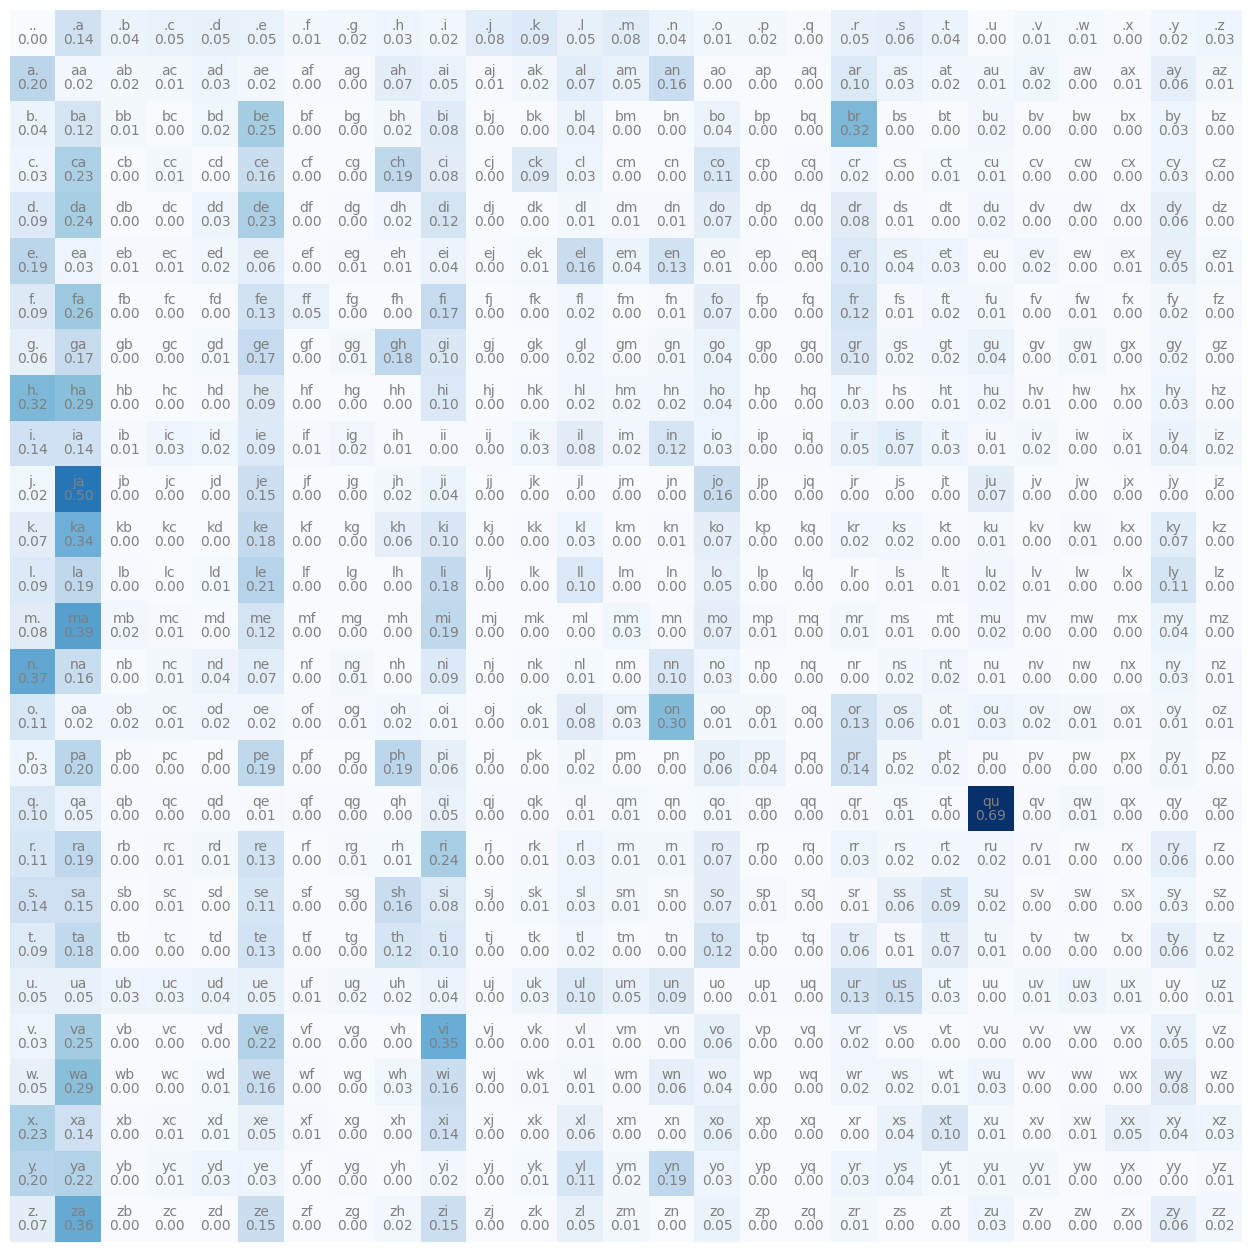

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(N)

# a better visual of the probabilities
plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr, ha="center", va="bottom", color='gray')
        plt.text(j,i,N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')

### Character Bigram Probabilities

To generate new name-like words, the character bigram counts are converted into probabilities. Laplace smoothing is applied (adding 1 to each count) to avoid zero probabilities. The probabilities are normalized to create a transition probability matrix.

In [ ]:
P = (N+1).float() # update (N + 1) model optimization to avoid infinite negative log likelihood
P /= P.sum(1, keepdim=True)

### Visualizing Character Bigram Probabilities <a name="visualizing-character-bigram-probabilities"></a>

The character bigram probabilities are visualized using a heatmap, giving a clearer picture of the transition probabilities between characters.

(-0.5, 26.5, 26.5, -0.5)

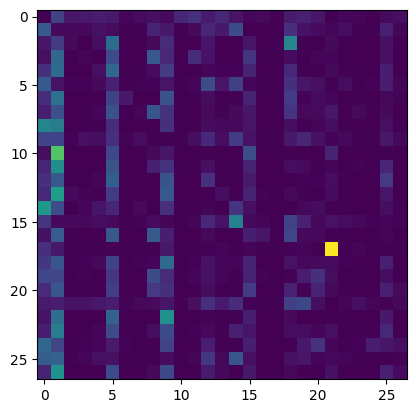

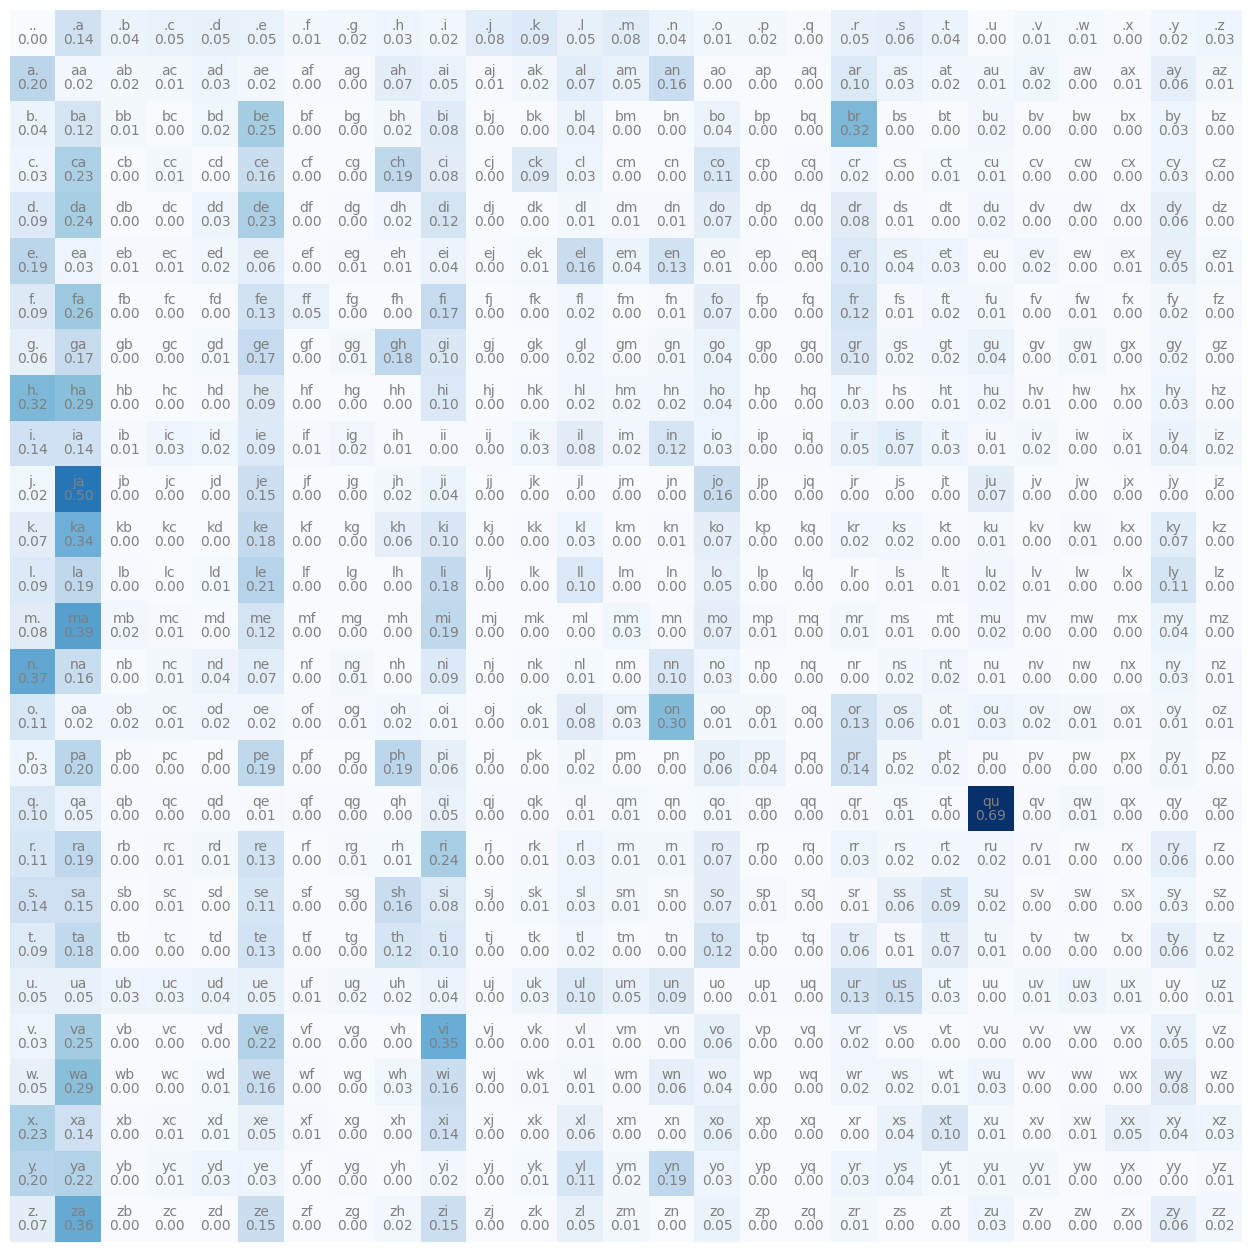

In [14]:
plt.imshow(P)

# a better visual of the probabilities
plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr, ha="center", va="bottom", color='gray')
        plt.text(j,i,f"{P[i,j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off')

### Iterative Sampling

The script demonstrates iterative sampling by generating new name-like words. It starts with the initial special character, samples the next character based on the probabilities, and continues until it reaches the end character.

In [17]:
g = torch.Generator().manual_seed(46)

for i in range(5):
    ix = 0
    out = []
    while True:
        p = P[ix]

        # for p to be a uniform distribution
        # p = torch.ones(27) / 27.0 
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break # the end token
    print("".join(out))

benamaha.
kynilalos.
stanoustiei.
labrein.
del.


### Loss Function

In the context of this project, we evaluate the performance of our models by using a loss function. The fundamental theory behind this evaluation is based on likelihood, which is essentially the product of probabilities. However, when dealing with numerous probabilities, their product can become exceedingly small. To mitigate this issue, we employ the concept of taking the logarithm of the product of probabilities.

Mathematically, this involves taking the logarithm of the product of probabilities, which can be represented as:

log(a * b * c) = log(a) + log(b) + log(c)

This transformation allows us to work with a more manageable range of values. By applying this concept, we calculate the log likelihood for our models.

The negative mean of the log likelihood is used as our loss function. This loss function quantifies how well our models predict character transitions within the dataset. It serves as a measure of the quality and accuracy of our word generation models.

In [18]:
# Evaluating and loss calculation
log_likelihood = 0.0
n = 0
for name in data:
    word = f"{special_char}{name}{special_char}"
    for ch1, ch2 in zip(word, word[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

nll = -log_likelihood
print(f"log likelihood: {log_likelihood.item()}")
print(f"negative log likelihood: {nll.item()}")
print(f"mean negative log likelihood: {nll/n}")

log likelihood: -559951.5625
negative log likelihood: 559951.5625
mean negative log likelihood: 2.4543561935424805
